In [9]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [10]:
### Function to convert dataframe to timeseries object
def create_ts_object(df):
    df.Timestamp = pd.to_datetime(df.Timestamp)
    df.set_index("Timestamp", inplace=True)
    df = df.asfreq('H')

    return df.head()

### Import Digester 25 data

In [11]:
data25 = pd.read_csv("~/Documents/Data/FinalDatasetForModel/Digester25data.csv")
data25.drop(['Dig_25_woodload', 'Dig_25_Liq_circ',
       'Digester_25_temperature', 'Digester_25_pressure',
       'Dig_25_phase_Comm Fail', 'Dig_25_phase_Configure',
       'Dig_25_phase_HP GAS RELEASE',
       'Dig_25_phase_LP GAS RELEASE', 'Dig_25_phase_PULP DISCHARGE', 'Dig_25_phase_READY FOR PULP DISCH',
       'Dig_25_phase_READY FOR STEAMING', 'Dig_25_phase_READY FOR WOOD',
       'Dig_25_phase_SFACTOR TGT REACHED', 'Dig_25_phase_SMOOTH STEAM FIXED',
       'Dig_25_phase_SMOOTH STEAM RAMP', 'Dig_25_phase_Scan Timeout',
       'Dig_25_phase_TEMP RAMP TO 110C', 'Dig_25_phase_TEMP RAMP TO 126C',
       'Dig_25_phase_TEMP RAMP TO TMAX', 'Dig_25_phase_VALVE CHECK',
       'Dig_25_phase_WOODLOAD COMPLETE', 'Dig_25_phase_WOODLOADING', 
       'Dig_25_phase_LIQOUR LOADING', 'Dig_25_phase_OUT OF SERVICE', 'Dig_25_phase_READY FOR LIQOUR'], axis = 1, inplace=True)

create_ts_object(data25)

,Dig_25_HX
Timestamp,
2020-11-01 00:00:00,0.000000
2020-11-01 01:00:00,0.000000
2020-11-01 02:00:00,0.190168
2020-11-01 03:00:00,0.000000
2020-11-01 04:00:00,0.009142


### Stationarity

In [12]:
sts.adfuller(data25.Dig_25_HX)

(-11.592467513827598,
 2.7706632254260955e-21,
 11,
 2197,
 {'1%': -3.433329953061165,
  '5%': -2.8628564476416725,
  '10%': -2.5674708095410446},
 13817.151322942274)

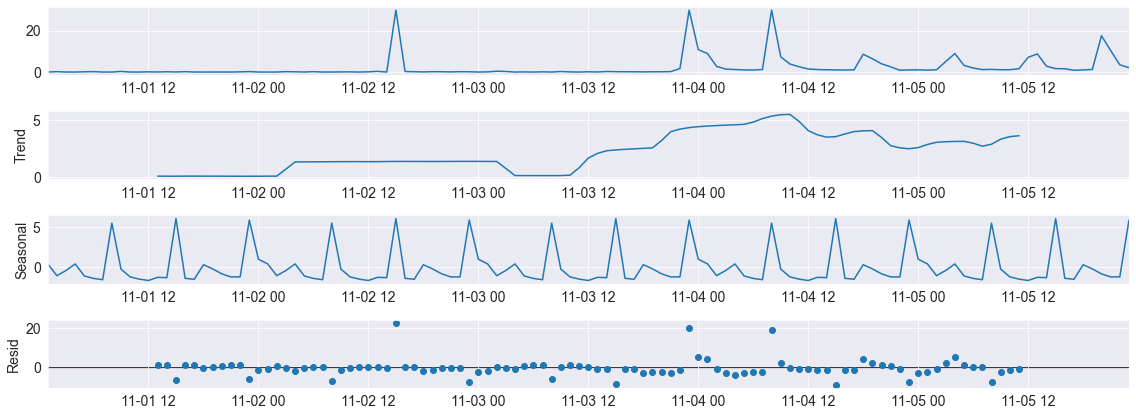

In [13]:
seas_dec = seasonal_decompose(data25[1:120], model = "additive")
seas_dec.plot()
plt.show()

### ACF

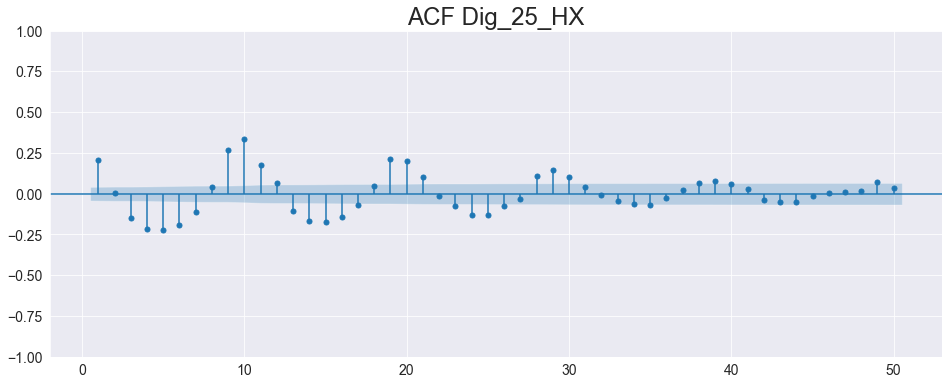

In [14]:
sgt.plot_acf(data25.Dig_25_HX, lags = 50, zero = False)
plt.title("ACF Dig_25_HX", size = 24)
plt.show()

### PACF

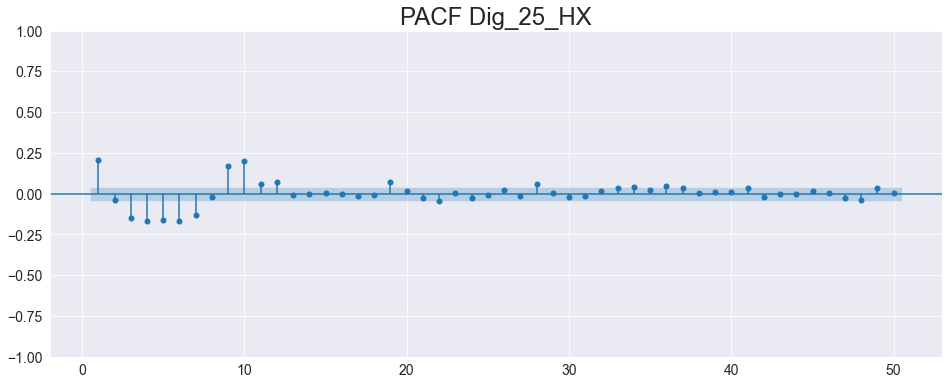

In [15]:
sgt.plot_pacf(data25.Dig_25_HX, lags = 50, zero = False, method = ('ols'))
plt.title("PACF Dig_25_HX", size = 24)
plt.show()

In [16]:
#  Spare copy
data25_twin1 = data25.copy()

### Normalization

In [17]:
# define functions to scale and reverse-scale data, looping through the columns, and passing a scaler type
def scale_data(data, scaler):
    for col in data.columns.values:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data.head()

In [18]:
scaler = MinMaxScaler()
data25_twin = data25.copy()
scale_data(data25_twin, scaler)

,Dig_25_HX
Timestamp,
2020-11-01 00:00:00,0.000000
2020-11-01 01:00:00,0.000000
2020-11-01 02:00:00,0.006339
2020-11-01 03:00:00,0.000000
2020-11-01 04:00:00,0.000305


### Data Split

In [19]:
train_size = int(len(data25_twin)*0.85)
val_size = train_size + int(len(data25_twin)*0.10)
train_data25 = data25_twin.iloc[:train_size]
val_data25 = data25_twin.iloc[train_size:val_size]
test_data25 = data25_twin.iloc[val_size:]

In [20]:
val_data25.head()

,Dig_25_HX
Timestamp,
2021-01-18 05:00:00,0.109239
2021-01-18 06:00:00,0.044168
2021-01-18 07:00:00,0.034140
2021-01-18 08:00:00,0.037100
2021-01-18 09:00:00,0.041717


### Auto ARIMA Model

In [21]:
model_auto = auto_arima(train_data25.Dig_25_HX, max_order = None, max_p = 30, max_q = 40, maxiter = 100, alpha = 0.05, n_jobs = -1, trend = 'ct',)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [22]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1877
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 225.538
Date:                Sat, 12 Mar 2022   AIC                           -437.075
Time:                        13:33:02   BIC                           -398.317
Sample:                             0   HQIC                          -422.798
                               - 1877                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.002      0.367      0.714      -0.003       0.004
drift      -7.072e-07   9.84e-07     -0.718      0.472   -2.64e-06    1.22e-06
ar.L1         -0.5454      0.187     -2.914      0.004      -0.912      -0.179
ma.L1         -0.1256      0.186     -0.676      0.499      -0.490       0.239
ma.L2         -0.5115      0.150     -3.412      0.001      -0.805      -0.218
ma.L3         -0.2666      0.063     -4.228      0.000      -0.390      -0.143
sigma2         0.0477      0.002     25.287      0.000       0.044       0.051
===================================================================================
Ljung-Box (L1) (Q):                  15.49   Jarque-Bera (JB):              9151.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             2.99
Prob(H) (two-sided):                  0.51   Kurtosis:                        12.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA Model Residual Analysis

In [23]:
data25_resid_dataset = train_data25.copy()
data25_resid_dataset['residuals'] = model_auto.resid()

In [24]:
print(data25_resid_dataset.residuals.mean())
print(data25_resid_dataset.residuals.var())

0.0019891364627708384
0.04595303237213039


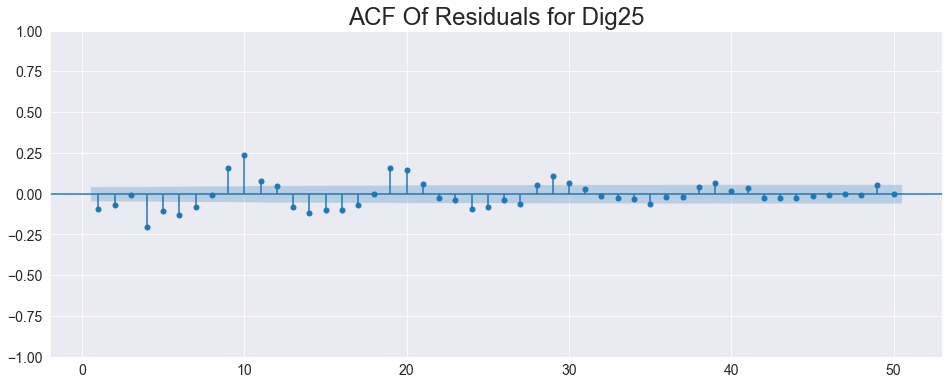

In [25]:
sgt.plot_acf(data25_resid_dataset.residuals, zero = False, lags = 50)
plt.title("ACF Of Residuals for Dig25",size=24)
plt.show()

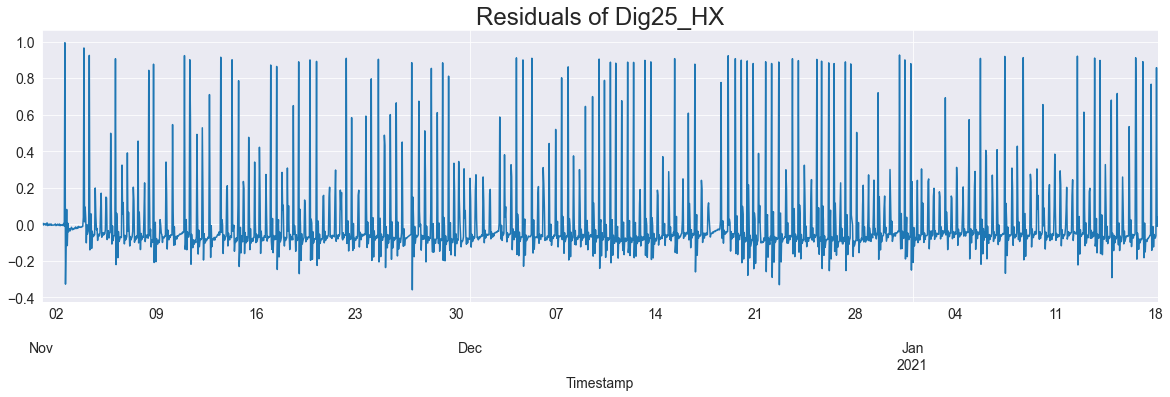

In [26]:
data25_resid_dataset.residuals.plot(figsize=(20,5))
plt.title("Residuals of Dig25_HX",size=24)
plt.show()

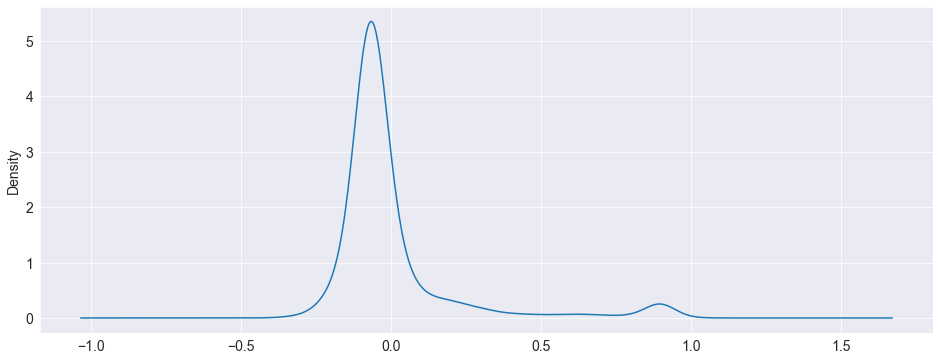

In [27]:
data25_resid_dataset.residuals.plot(kind='kde')
plt.show()

### Model Validation

In [28]:
start_date = "2021-01-18 05:00:00"
end_date = "2021-01-27 08:00:00"

In [29]:
df_pred = pd.DataFrame(model_auto.predict(n_periods = len(val_data25), index = val_data25.index))

In [30]:
scaler2 = MinMaxScaler()
scaler2.fit_transform(data25_twin1.Dig_25_HX.values.reshape(-1, 1))

array([[0.        ],
       [0.        ],
       [0.00633895],
       ...,
       [0.03606361],
       [0.03375309],
       [0.03787792]])

In [31]:
# Invert the scale of predictions
df_pred2 = scaler2.inverse_transform(df_pred.values.reshape(-1, 1))

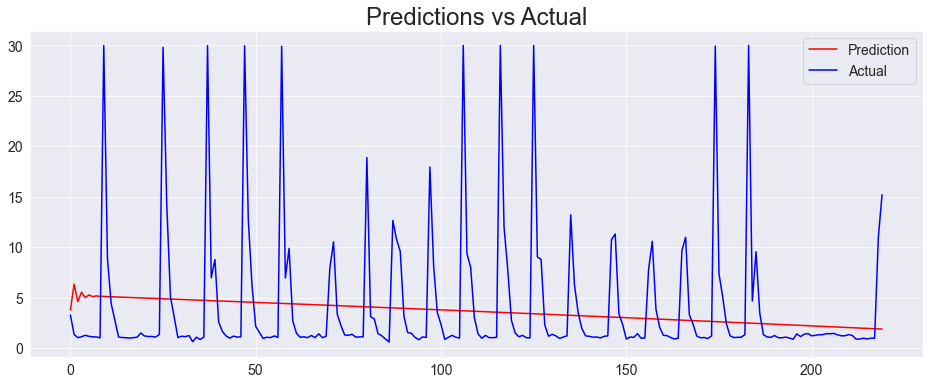

In [32]:
plt.plot(df_pred.index.to_numpy(), df_pred2, color = "red")
plt.plot(df_pred.index, data25_twin1.Dig_25_HX[start_date:end_date].to_numpy(), color = "blue")
plt.legend(['Prediction', 'Actual'])
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Performance Metrics

In [33]:
ndapred, ndaactual = df_pred, val_data25.Dig_25_HX.to_numpy()

In [34]:
print(ndapred.shape)
print(ndaactual.shape)

(220, 1)
(220,)


In [35]:
print("MAE: %.4f" %mean_absolute_error(ndaactual, ndapred))
print("RMSE: %.4f" %np.sqrt(mean_squared_error(ndaactual, ndapred)))

MAE: 0.1326
RMSE: 0.2214


In [36]:
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/Dig25pred.npy", df_pred2)

### Forecast

In [37]:
fcast = pd.DataFrame(model_auto.predict(n_periods = len(test_data25), index = test_data25.index))

In [42]:
fcast = scaler2.inverse_transform(fcast.values.reshape(-1, 1))

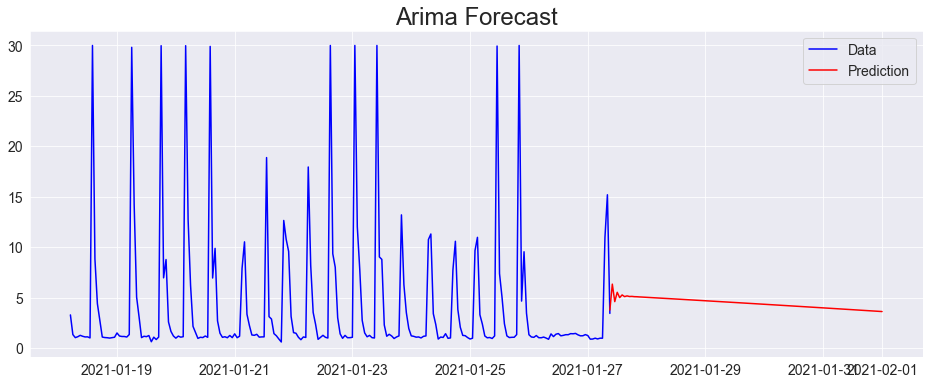

In [43]:
plt.plot(data25_twin1.index[1877:2098], data25_twin1.Dig_25_HX[1877:2098].to_numpy(), color = "blue")
plt.plot(test_data25.index, fcast, color = "red")
plt.legend(['Data', 'Prediction'])
plt.title("Arima Forecast", size = 24)
plt.show()

In [41]:
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/Dig25fcast.npy", fcast)
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/ValTestIndex.npy", data25_twin1.index[1877:])